#### Data & Libraries

In [2]:
'''Data & Libraries
PSDS_PATH <- file.path(dirname(dirname(getwd())))

loan3000 <- read.csv(file.path(PSDS_PATH, 'data', 'loan3000.csv'), stringsAsFactors=TRUE)
loan_data <- read.csv(file.path(PSDS_PATH, 'data', 'loan_data.csv.gz'), stringsAsFactors=TRUE)
full_train_set <- read.csv(file.path(PSDS_PATH, 'data', 'full_train_set.csv.gz'), stringsAsFactors=TRUE)

# order the outcome variable
loan3000$outcome <- ordered(loan3000$outcome, levels=c('paid off', 'default'))
loan_data$outcome <- ordered(loan_data$outcome, levels=c('paid off', 'default'))
full_train_set$outcome <- ordered(full_train_set$outcome, levels=c('paid off', 'default'))

library(klaR)
library(MASS)
library(dplyr)
library(ggplot2)
library(FNN)
library(mgcv)
library(rpart)'''

ERROR: Error in parse(text = x, srcfile = src): <text>:1:3: 예상하지 못한 문자열 상수(string constant)입니다.
3: 
4: loan3000 <- read.csv(file.path(PSDS_PATH, '
     ^


#### Done

### 5.1 나이브 베이즈

In [1]:
# 대출 데이터 불러오기
data_path = '/Users/youngeun/prac_stat/data'
loan_data <- read.csv(file.path(data_path, 'loan_data.csv.gz'), stringsAsFactors=TRUE)

###### loan data peek 👀

In [2]:
head(loan_data)

,X,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,⋯,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
,<int>,<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<int>,<dbl>,<fct>,⋯,<int>,<int>,<int>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>
1,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,⋯,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
2,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,⋯,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
3,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,⋯,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
4,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,⋯,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
5,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,⋯,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55
6,6,Charged Off,21000,36 months,105000,13.22,8.01977,32135,90.3,debt_consolidation,⋯,1,1,7,5.8,default,11,debt_consolidation,RENT,> 1 Year,0.40


In [4]:
levels(loan_data$outcome)

[1] "default"  "paid off"

###### done

In [5]:
# 라이브러리 불러오기 
#install.packages('klaR')
library(klaR)

필요한 패키지를 로딩중입니다: MASS



In [6]:
naive_model <- NaiveBayes(outcome ~ purpose_ + home_ + emp_len_, data = na.omit(loan_data))

In [7]:
naive_model$table

$purpose_
          var
grouping   credit_card debt_consolidation home_improvement major_purchase
  default   0.15151515         0.57571347       0.05981209     0.03727229
  paid off  0.18759649         0.55215915       0.07150104     0.05359270
          var
grouping      medical      other small_business
  default  0.01433549 0.11561025     0.04574126
  paid off 0.01424728 0.09990737     0.02099599

$home_
          var
grouping    MORTGAGE       OWN      RENT
  default  0.4313440 0.0832782 0.4853778
  paid off 0.4894800 0.0808963 0.4296237

$emp_len_
          var
grouping     < 1 Year   > 1 Year
  default  0.04728508 0.95271492
  paid off 0.03105289 0.96894711


In [8]:
# 새로운 대출에 대한 결과 예측
new_loan <- loan_data[147, c('purpose_', 'home_', 'emp_len_')]
new_loan

,purpose_,home_,emp_len_
,<fct>,<fct>,<fct>
147,small_business,MORTGAGE,> 1 Year


In [9]:
row.names(new_loan) <- NULL # 행 이름? 원래 인덱스 제거 
new_loan

purpose_,home_,emp_len_
<fct>,<fct>,<fct>
small_business,MORTGAGE,> 1 Year


In [10]:
# 예측 
predict(naive_model, new_loan) # default의 확률이 더 높계 예측됨 

default,paid off
0.6536987,0.3463013


### 5.2 LDA

In [4]:
data_path = '/Users/youngeun/prac_stat/data'
loan3000 <- read.csv(file.path(data_path, 'loan3000.csv'), stringsAsFactors=TRUE)

In [5]:
library(MASS)

In [8]:
loan_lda <- lda(outcome ~ borrower_score + payment_inc_ratio, data=loan3000)

In [18]:
head(loan_lda)

$prior
  default  paid off 
0.4816667 0.5183333 

$counts
 default paid off 
    1445     1555 

$means
         borrower_score payment_inc_ratio
default       0.4628028          8.861813
paid off      0.5390675          7.465199

$scaling
                          LD1
borrower_score     7.17583880
payment_inc_ratio -0.09967559

$lev
[1] "default"  "paid off"

$svd
[1] 18.78717

In [9]:
# discriminator weight
loan_lda$scaling 

,LD1
borrower_score,7.17583880
payment_inc_ratio,-0.09967559


In [10]:
# class probabilities
pred <- predict(loan_lda)
head(pred$posterior)

,default,paid off
1,0.5535437,0.4464563
2,0.5589534,0.4410466
3,0.2726962,0.7273038
4,0.5062538,0.4937462
5,0.6099525,0.3900475
6,0.4107406,0.5892594


In [15]:
typeof(pred)

[1] "list"

In [19]:
# visualization 
center <- 0.5 * (loan_lda$mean[1, ] + loan_lda$mean[2, ]) # 두 클래스 평균의 중심점
slope <- -loan_lda$scaling[1] / loan_lda$scaling[2] # w_x * x + w_z * z = 0 -> w_z * z = -w_x * x -> z / x = -w_x / w_z
intercept <- center[2] - center[1] * slope # y = 기울기 * x + 절편 -> 절편 = y - 기울기 * x 

In [23]:
lda_df <- cbind(loan3000, prob_default=pred$posterior[,'default'])

In [28]:
library(ggplot2)

Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`).”


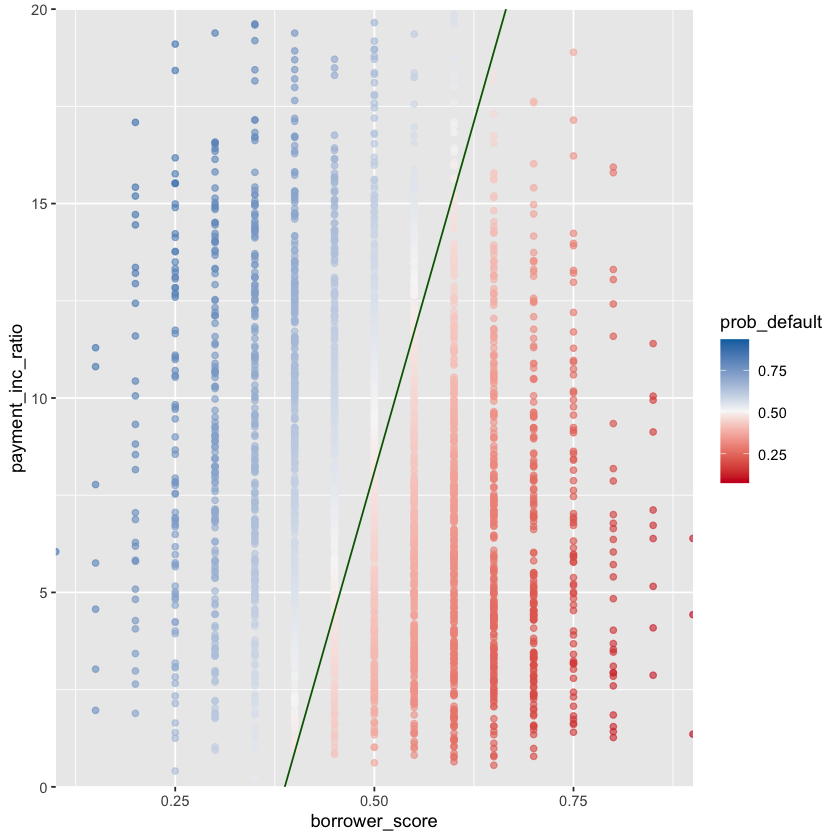

In [31]:
ggplot(data=lda_df, aes(x=borrower_score, y=payment_inc_ratio, color=prob_default)) + 
geom_point(alpha=.6) + 
scale_color_gradientn(colors=c('#ca0020', '#f7f7f7', '#0571b0')) + # gradient가 아니라 gradientn
scale_x_continuous(expand=c(0, 0)) + 
scale_y_continuous(expand=c(0, 0), lim=c(0, 20)) + 
geom_abline(slope=slope, intercept=intercept, color='darkgreen')

### 5.3 로지스틱 회귀

In [1]:
# 대출 데이터 불러오기
data_path = '/Users/youngeun/prac_stat/data'
loan_data <- read.csv(file.path(data_path, 'loan_data.csv.gz'), stringsAsFactors=TRUE)

In [2]:
# order the outcome variable
loan_data$outcome <- ordered(loan_data$outcome, levels=c('paid off', 'default'))

In [3]:
logistic_model <- glm(outcome ~ payment_inc_ratio + purpose_ + home_ + emp_len_ + borrower_score, data=loan_data, family='binomial')

In [4]:
logistic_model


Call:  glm(formula = outcome ~ payment_inc_ratio + purpose_ + home_ + 
    emp_len_ + borrower_score, family = "binomial", data = loan_data)

Coefficients:
               (Intercept)           payment_inc_ratio  
                   1.63809                     0.07974  
purpose_debt_consolidation    purpose_home_improvement  
                   0.24937                     0.40774  
    purpose_major_purchase             purpose_medical  
                   0.22963                     0.51048  
             purpose_other      purpose_small_business  
                   0.62066                     1.21526  
                  home_OWN                   home_RENT  
                   0.04833                     0.15732  
         emp_len_ > 1 Year              borrower_score  
                  -0.35673                    -4.61264  

Degrees of Freedom: 45341 Total (i.e. Null);  45330 Residual
Null Deviance:	    62860 
Residual Deviance: 57510 	AIC: 57540

In [5]:
sapply(loan_data, function(x) if (is.factor(x)) levels(x) else NULL)

$X
NULL

$status
[1] "Charged Off" "Default"     "Fully Paid" 

$loan_amnt
NULL

$term
[1] "36 months" "60 months"

$annual_inc
NULL

$dti
NULL

$payment_inc_ratio
NULL

$revol_bal
NULL

$revol_util
NULL

$purpose
 [1] "car"                "credit_card"        "debt_consolidation"
 [4] "home_improvement"   "house"              "major_purchase"    
 [7] "medical"            "moving"             "other"             
[10] "small_business"     "vacation"           "wedding"           

$home_ownership
[1] "MORTGAGE" "OTHER"    "OWN"      "RENT"    

$delinq_2yrs_zero
NULL

$pub_rec_zero
NULL

$open_acc
NULL

$grade
NULL

$outcome
[1] "paid off" "default" 

$emp_length
NULL

$purpose_
[1] "credit_card"        "debt_consolidation" "home_improvement"  
[4] "major_purchase"     "medical"            "other"             
[7] "small_business"    

$home_
[1] "MORTGAGE" "OWN"      "RENT"    

$emp_len_
[1] " < 1 Year" " > 1 Year"

$borrower_score
NULL

In [6]:
# logistic model로부터 얻은 예측값: 로그 오즈값 
pred <- predict(logistic_model)
summary(pred)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-2.704774 -0.518825 -0.008539  0.002564  0.505061  3.509606 

In [7]:
# 로그 오즈값 -> 확률
prob = 1/(1+exp(-pred))
summary(prob)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.06269 0.37313 0.49787 0.50000 0.62365 0.97096 

In [9]:
# 모델 평가 
summary(logistic_model)


Call:
glm(formula = outcome ~ payment_inc_ratio + purpose_ + home_ + 
    emp_len_ + borrower_score, family = "binomial", data = loan_data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.51951  -1.06908  -0.05853   1.07421   2.15528  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 1.638092   0.073708  22.224  < 2e-16 ***
payment_inc_ratio           0.079737   0.002487  32.058  < 2e-16 ***
purpose_debt_consolidation  0.249373   0.027615   9.030  < 2e-16 ***
purpose_home_improvement    0.407743   0.046615   8.747  < 2e-16 ***
purpose_major_purchase      0.229628   0.053683   4.277 1.89e-05 ***
purpose_medical             0.510479   0.086780   5.882 4.04e-09 ***
purpose_other               0.620663   0.039436  15.738  < 2e-16 ***
purpose_small_business      1.215261   0.063320  19.192  < 2e-16 ***
home_OWN                    0.048330   0.038036   1.271    0.204    
home_RENT                   0.

In [11]:
# 로지스틱 회귀 확장 - 일반화가법모형이용
library(mgcv)
# s(): 스플라인 함수
logistic_gam <- gam(outcome ~ s(payment_inc_ratio) + purpose_ + home_ + emp_len_ + s(borrower_score), data=loan_data, family='binomial')

필요한 패키지를 로딩중입니다: nlme

This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.



In [25]:
logistic_gam 


Family: binomial 
Link function: logit 

Formula:
outcome ~ s(payment_inc_ratio) + purpose_ + home_ + emp_len_ + 
    s(borrower_score)

Estimated degrees of freedom:
7.66 4.17  total = 21.83 

UBRE score: 0.2681506     

In [24]:
summary(logistic_gam)


Family: binomial 
Link function: logit 

Formula:
outcome ~ s(payment_inc_ratio) + purpose_ + home_ + emp_len_ + 
    s(borrower_score)

Parametric coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -0.02833    0.05702  -0.497    0.619    
purpose_debt_consolidation  0.24836    0.02763   8.988  < 2e-16 ***
purpose_home_improvement    0.40994    0.04678   8.763  < 2e-16 ***
purpose_major_purchase      0.23762    0.05395   4.405 1.06e-05 ***
purpose_medical             0.51696    0.08705   5.939 2.87e-09 ***
purpose_other               0.62777    0.03981  15.768  < 2e-16 ***
purpose_small_business      1.22389    0.06344  19.294  < 2e-16 ***
home_OWN                    0.04964    0.03805   1.305    0.192    
home_RENT                   0.15788    0.02122   7.441 1.00e-13 ***
emp_len_ > 1 Year          -0.35323    0.05264  -6.711 1.94e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significa

In [13]:
# 편잔차 계산
terms <- predict(logistic_gam, type='terms') #  각 예측 변수가 결과 변수에 미치는 영향을 개별적으로 계산한 값

In [14]:
head(terms)

,purpose_,home_,emp_len_,s(payment_inc_ratio),s(borrower_score)
1,0.2376184,0.15787721,-0.3532268,-0.431381429,-0.6697753
2,1.2238889,0.04964275,-0.3532268,-0.299303624,-1.4789659
3,0.6277718,0.15787721,-0.3532268,0.126333526,-0.4497498
4,0.2483625,0.15787721,-0.3532268,0.449024784,-0.0122596
5,0.6277718,0.15787721,-0.3532268,-0.328799362,-0.2336298
6,0.2483625,0.15787721,-0.3532268,-0.008563808,0.4426327


In [15]:
partial_resid <- resid(logistic_model) + terms # 편잔차: 단일 예측변수를 기반으로 한 예측값과 전체를 고려한 회귀식의 실제 잔차를 결합

In [17]:
df <- data.frame(payment_inc_ratio = loan_data[, 'payment_inc_ratio'],
                 terms = terms[, 's(payment_inc_ratio)'],
                 partial_resid = partial_resid[, 's(payment_inc_ratio)'])

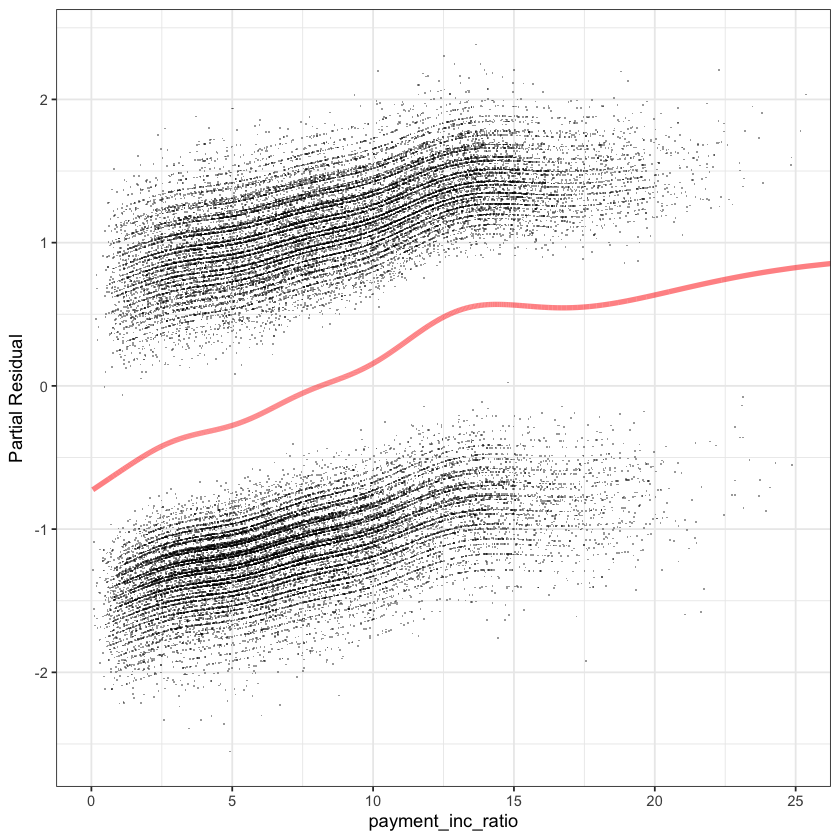

In [23]:
library(ggplot2)
ggplot(df, aes(x=payment_inc_ratio, y=partial_resid, solid=FALSE)) +
    geom_point(shape=46, alpha=0.4) + 
    geom_line(aes(x=payment_inc_ratio, y=terms),
              color = 'red', alpha=0.5, linewidth=1.5) +
    labs(y='Partial Residual') +
    coord_cartesian(xlim=c(0, 25)) + # 그래프의 좌표계 설정. x축의 범위를 지정하여 특정 구간만 확대하거나 시각화
    theme_bw()

### 5.4 분류 모델 평가하기

In [1]:
# logistic_gam 모델의 혼동행렬 계산하기 
## 데이터 불러오기
data_path = '/Users/youngeun/prac_stat/data'
loan_data <- read.csv(file.path(data_path, 'loan_data.csv.gz'), stringsAsFactors=TRUE)
loan_data$outcome <- ordered(loan_data$outcome, levels=c('paid off', 'default'))

## 모델 불러오기 
library(mgcv)
logistic_gam <- gam(outcome ~ s(payment_inc_ratio) + purpose_ + home_ + emp_len_ + s(borrower_score), data=loan_data, family='binomial')

필요한 패키지를 로딩중입니다: nlme

This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.



In [2]:
# 전체 훈련 데이터 적용 
pred <- predict(logistic_gam, new_data=loan_data)
# 확률 p가 0.5일 때: 오즈 p/1-p = 1이 되고, 로그 오즈 log(1) = 0
pred_y <- as.numeric(pred > 0)
true_y <- as.numeric(loan_data$outcome=='default')

In [3]:
true_pos <- (true_y==1) & (pred_y==1)
true_neg <- (true_y==0) & (pred_y==0)

# false 다음에 오는 건 예측 결과가 어떻게 나왔는지 
false_pos <- (true_y==0) & (pred_y==1)
false_neg <- (true_y==1) & (pred_y==0)

In [4]:
conf_mat <- matrix(c(sum(true_pos), sum(false_pos), sum(false_neg), sum(true_neg)), 2, 2)

In [5]:
colnames(conf_mat) <- c('Yhat=1', 'Yhat=0')
rownames(conf_mat) <- c('Y=1', 'Y=0')

In [6]:
conf_mat

,Yhat=1,Yhat=0
Y=1,14293,8378
Y=0,8051,14620


In [7]:
precision <- conf_mat[1, 1] / (conf_mat[1, 1] + conf_mat[2, 1]) # sum(conf_mat[, 1])
precision

[1] 0.6396796

In [8]:
recall <- conf_mat[1, 1] / (conf_mat[1, 1] + conf_mat[1, 2]) # sum(conf_mat[1,])
recall

[1] 0.630453

In [9]:
specificity <- conf_mat[2, 2] / (conf_mat[2, 1] + conf_mat[2, 2]) # sum(conf_mat[2,])
specificity

[1] 0.6448767

In [12]:
head(pred)

1           2           3           4           5           6 
-1.08721693 -0.88629367  0.08067709  0.46144919 -0.15833583  0.45875292

In [37]:
# ROC 곡선
idx <- order(-pred) # pred(=로짓)값이 클 수록 1이 될 확률이 높음 -> order은 오름차순 정렬 -> 음수로 순서를 뒤집었기 때문에 가장 1이 되기 쉬운 레코드의 인덱스가 앞으로 옴
## 정렬 -> 누적 재현율
recall <- cumsum(true_y[idx] == 1) / sum(true_y == 1) # 분자: (정렬 후) 이번 record까지의 참 양성(예측도, 실제도 양성인) 개수 / 분모: 전체 양성 데이터 개수 
## 정렬 -> 누적 특이도
specificity <- (sum(true_y[idx] == 0) - cumsum(true_y[idx] == 0)) / sum(true_y == 0)

In [38]:
roc_df <- data.frame(recall = recall, specificity = specificity)

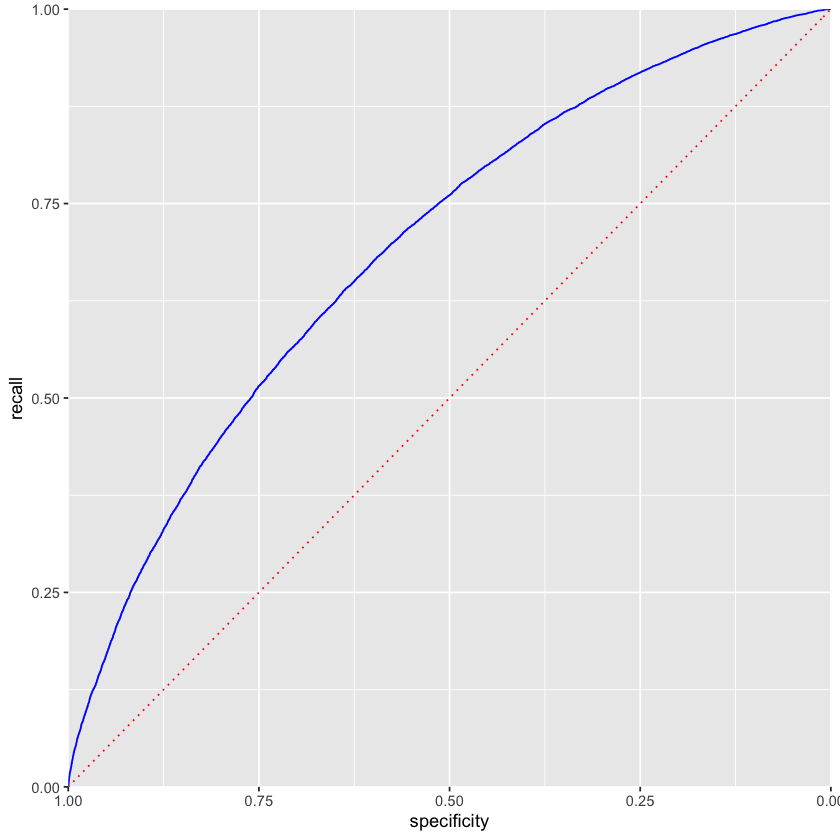

In [39]:
library(ggplot2)
ggplot(roc_df, aes(x=specificity, y=recall)) +
    geom_line(color='blue') +
    scale_x_reverse(expand=c(0, 0)) + 
    scale_y_continuous(expand=c(0, 0)) +
    # 0.00~1.00
    geom_line(data = data.frame(x=(0:100) / 100), aes(x=x, y=1-x), linetype='dotted', color='red')    

In [59]:
# AUC - 수치 적분 이용 
sum(roc_df$recall[-1] * diff(1 - roc_df$specificity))

[1] 0.6926232

In [69]:
# 마지막 요소 제외해도 값이 같다...why? 
sum(roc_df$recall[-nrow(roc_df)] * diff(1 - roc_df$specificity))

[1] 0.6926232

### 5.5 불균형 데이터 다루기 

In [1]:
data_path = '/Users/youngeun/prac_stat/data'
# 원래 대출 데이터의 0/1 개수 
loan_data <- read.csv(file.path(data_path, 'loan_data.csv.gz'), stringsAsFactors=TRUE)

In [2]:
table(loan_data$outcome) # 50:50


 default paid off 
   22671    22671 

In [5]:
full_train_set <- read.csv(file.path(data_path, 'full_train_set.csv.gz'), stringsAsFactors=TRUE)

In [6]:
table(full_train_set$outcome) # paid_off가 훨씬 많다 


 default paid off 
   22671    97316 

In [7]:
mean(full_train_set$outcome == 'default')

[1] 0.1889455

In [8]:
full_model <- glm(outcome ~ payment_inc_ratio + purpose_ + home_ + emp_len_ + dti + revol_bal + revol_util,
                  data=full_train_set, family='binomial')

In [9]:
pred <- predict(full_model) # fitting 후 계수를 가지고, train_X들을 input으로 받았을 때 y값 예측

In [10]:
mean(pred > 0) # paid_off가 1으로 되어 있는 상황 

[1] 0.9960579

In [15]:
# outcome label 재정렬
full_train_set$outcome <- ordered(full_train_set$outcome, levels=c('paid off', 'default'))

In [16]:
full_model <- glm(outcome ~ payment_inc_ratio + purpose_ + home_ + emp_len_ + dti + revol_bal + revol_util,
                  data=full_train_set, family='binomial')
pred <- predict(full_model)
mean(pred > 0)

[1] 0.003942094

In [18]:
# 가중치 이용하여 upsampling
upsampling_wt = 1/mean(full_train_set$outcome == 'default')
upsampling_wt

[1] 5.292532

In [19]:
wt <- ifelse(full_train_set$outcome == 'default', upsampling_wt, 1)

In [21]:
full_model <- glm(outcome ~ payment_inc_ratio + purpose_ + home_ + emp_len_ + dti + revol_bal + revol_util,
                  data=full_train_set, weight=wt, family='quasibinomial')

In [22]:
pred <- predict(full_model)
mean(pred > 0)

[1] 0.5767208

In [1]:
# 서로 다른 모델 간 예측 결과 분석
library(rpart) # tree
library(ggplot2) # graph
library(MASS) # lda
library(mgcv) # gam

필요한 패키지를 로딩중입니다: nlme

This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.



In [2]:
data_path = '/Users/youngeun/prac_stat/data'
loan3000 <- read.csv(file.path(data_path, 'loan3000.csv'), stringsAsFactors=TRUE)
loan3000$outcome <- ordered(loan3000$outcome, levels=c('paid off', 'default'))

In [3]:
# LDA
loan_lda <- lda(outcome ~ borrower_score + payment_inc_ratio,
                data=loan3000)

pred <- predict(loan_lda)
lda_df <- cbind(loan3000, prob_default=pred$posterior[,'default'])

center <- 0.5 * (loan_lda$mean[1, ] + loan_lda$mean[2, ])
slope <- -loan_lda$scaling[1] / loan_lda$scaling[2]
intercept = center[2] - center[1] * slope

geom_abline(slope=slope, intercept=intercept, color='darkgreen')

mapping: intercept = ~intercept, slope = ~slope 
geom_abline: na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

In [8]:
class(loan_lda)

[1] "lda"

In [9]:
names(loan_lda)

[1] "prior"   "counts"  "means"   "scaling" "lev"     "svd"     "N"      
 [8] "call"    "terms"   "xlevels"

In [6]:
loan_lda

Call:
lda(outcome ~ borrower_score + payment_inc_ratio, data = loan3000)

Prior probabilities of groups:
 paid off   default 
0.5183333 0.4816667 

Group means:
         borrower_score payment_inc_ratio
paid off      0.5390675          7.465199
default       0.4628028          8.861813

Coefficients of linear discriminants:
                          LD1
borrower_score    -7.17583880
payment_inc_ratio  0.09967559

In [7]:
loan_lda$mean

,borrower_score,payment_inc_ratio
paid off,0.5390675,7.465199
default,0.4628028,8.861813


In [10]:
loan_lda$mean[1,]

borrower_score payment_inc_ratio 
        0.5390675         7.4651989

In [11]:
loan_lda$mean[1,] +  loan_lda$mean[2,]

borrower_score payment_inc_ratio 
          1.00187          16.32701

In [12]:
center

borrower_score payment_inc_ratio 
        0.5009351         8.1635062

In [52]:
lda_pred <- data.frame(borrower_score = c((0 - intercept) / slope, (20 - intercept) / slope),
                       payment_inc_ratio = c(0, 20),
                       method = rep('LDA', 2))

In [53]:
# Tree
loan_tree <- rpart(outcome ~ borrower_score + payment_inc_ratio,
                   data=loan3000, 
                   control = rpart.control(cp=.005))

In [54]:
# tree 모델에서 구해야 할 것 같은데 그냥 값을 제공?
tree_pred <- data.frame(borrower_score = c(0.375, 0.375, 0.475, 0.475, 0.575, 0.575),
                        payment_inc_ratio = c(0, 4.426,  4.426, 10.42, 10.42, 20),
                        method = rep('Tree', 6))

In [55]:
# LR
glm0 <- glm(outcome ~ (payment_inc_ratio) +  (borrower_score),
            data=loan3000, family='binomial')
y <- seq(from=0, to=20, length=100)
x <- (-glm0$coefficients[1] - glm0$coefficients[2]*y)/glm0$coefficients[3]
glm0_pred <- data.frame(borrower_score=x, payment_inc_ratio=y, method='Logistic')

In [56]:
# gam + LR
## s: spline function
gam1 <- gam(outcome ~ s(payment_inc_ratio) +  s(borrower_score),
            data=loan3000, family='binomial')

## 특정 borrower_score 값에 대해 GAM 모델의 예측값의 제곱합을 계산하는 함수?
gam_fun <- function(x){
  rss <- sum(predict(gam1, newdata=data.frame(borrower_score=x, payment_inc_ratio=y))^2)
}

## 비선형 경계 최적화를 사용하여 RSS를 최소화하는 borrower_score 값 찾기?
est_x <- nlminb(seq(from=.33, to=.73, length=100), gam_fun)

gam1_pred <- data.frame(borrower_score=est_x$par, payment_inc_ratio=y, method="GAM")

In [57]:
loan_fits <- rbind(lda_pred,
                   tree_pred,
                   glm0_pred,
                   gam1_pred)

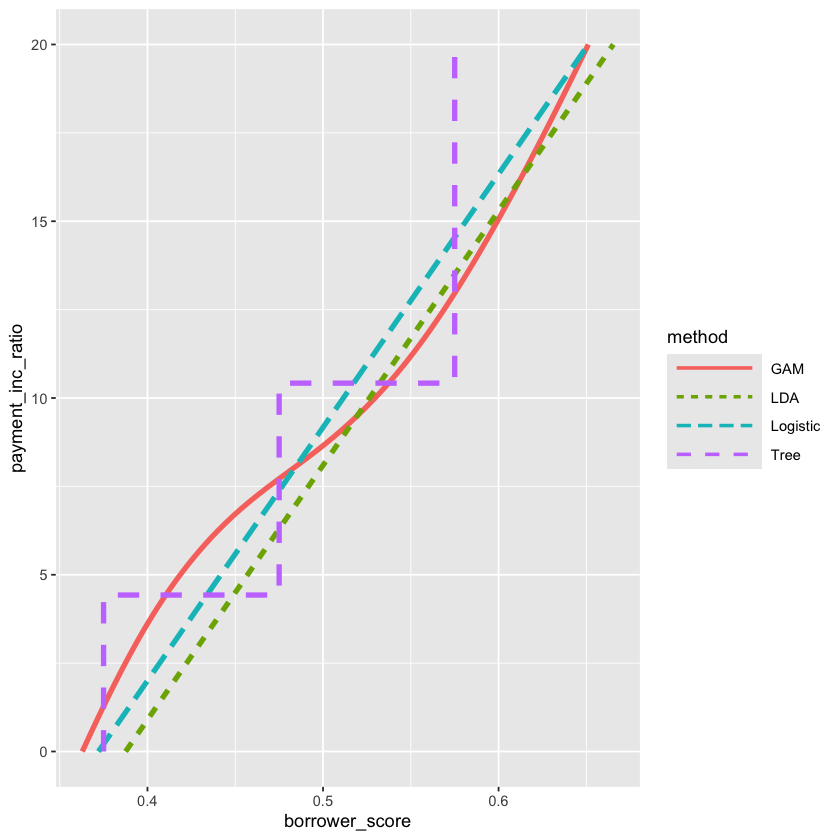

In [59]:
graph <- ggplot(data=loan_fits, aes(x=borrower_score, y=payment_inc_ratio, color=method, linetype=method)) +
  geom_line(size=1.5) +
  theme(legend.key.width = unit(2,"cm")) +
  guides(linetype = guide_legend(override.aes = list(linewidth = 1)))
graph